In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision.models import vgg16
import os 
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
from PIL import Image  # Image Load
import numpy as np
from matplotlib import pyplot #to show image
import xml.etree.ElementTree as ET # to get bndbox
import torch
from torch import nn
import torchvision # .opt.nms
import torch.nn.functional as F # softmax

In [ ]:
import tarfile

tar = tarfile.open("drive/MyDrive/voctar")
tar.extractall()
tar.close()

In [ ]:
#---upload pascal voc2007----"

#---download pascal voc2007----#
import requests
url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
r = requests.get(url, allow_redirects=True)
open('drive/MyDrive/voctar', 'wb').write(r.content)


460032000

In [ ]:
import tarfile

tar = tarfile.open("drive/MyDrive/voctar")
tar.extractall(path="drive/MyDrive")
tar.close()

(375, 500, 3)


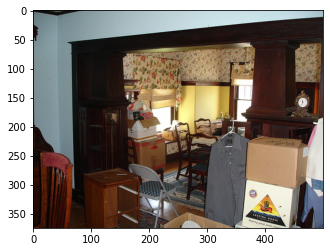

In [ ]:
data_dir = 'drive/MyDrive/VOCdevkit/VOC2007'
id = '000005'
img_file = os.path.join(data_dir, 'JPEGImages', id + '.jpg')
img = Image.open(img_file)
img = np.asarray(img, dtype=np.int32)

#print
print(img.shape)
pyplot.imshow(img, cmap="gray")



In [ ]:
#------ gather id -----#
ids = []
data_dir = 'drive/MyDrive/VOCdevkit/VOC2007'
img_dir = os.path.join(data_dir, 'JPEGImages')
anno_dir = os.path.join(data_dir, 'Annotations')

for file_name in os.listdir(img_dir):
  ids.append(file_name.split('.')[0])
ids.sort()
print(ids)

#------ compose dictionary (class -> idx), and get data ----- #
class_dict = {} #class to idx
class_names = []

class_idx = 0

images = []
bndboxes = []
classes = []
for id in ids:

  anno = ET.parse(os.path.join(anno_dir, id + '.xml'))
  for obj in anno.findall('object'):
    class_name = obj.find('name').text
    if class_name not in class_dict:
      class_dict[class_name] = class_idx
      class_idx += 1
      class_names.append(class_name)
    img_classes.append(class_dict[class_name])
      
    bndbox = obj.find('bndbox')
    img_bndboxes.append(
        [int(bndbox.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
    )
  bndboxes.append(img_bndboxes)
  classes.append(img_classes)

print(len(images), len(class_names))
print(class_names)

['000005', '000007', '000009', '000012', '000016', '000017', '000019', '000020', '000021', '000023', '000024', '000026', '000030', '000032', '000033', '000034', '000035', '000036', '000039', '000041', '000042', '000044', '000046', '000047', '000048', '000050', '000051', '000052', '000060', '000061', '000063', '000064', '000065', '000066', '000072', '000073', '000077', '000078', '000081', '000083', '000089', '000091', '000093', '000095', '000099', '000101', '000102', '000104', '000107', '000109', '000110', '000112', '000113', '000117', '000118', '000120', '000121', '000122', '000123', '000125', '000129', '000130', '000131', '000132', '000133', '000134', '000138', '000140', '000141', '000142', '000143', '000146', '000147', '000150', '000153', '000154', '000156', '000158', '000159', '000161', '000162', '000163', '000164', '000165', '000169', '000170', '000171', '000173', '000174', '000177', '000180', '000184', '000187', '000189', '000190', '000192', '000193', '000194', '000198', '000200',

In [ ]:
model = vgg16()

In [ ]:
print("torch.cuda", torch.cuda.is_available())
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#print(model.features)
extractor = model.features[:-1]
extractor.to(dev)

torch.cuda True


In [ ]:
#----basic dataset ----#
N = 1

for i in range(0, len(images), N):
  j = min(i + N, len(images))
  X = torch.tensor(images[i:j], dtype = torch.float, device = dev)
  X = X.permute(0, 3, 1, 2)
  break

normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
X /= 256
X = normalize(X)

print(X.size())
print(X[0,0])


In [ ]:
#----anchor-----#
import numpy as np

pixel = torch.tensor([64, 128, 256], device=dev)
ratio = torch.tensor([[1, 0.5, 1], 
                  [0.5, 1, 1]], device=dev)

ww=X[0].size(2)
hh=X[0].size(1)
feat_stride = 16

_anchor_x = torch.arange(feat_stride//2, ww, feat_stride, device=dev)
_anchor_y = torch.arange(feat_stride//2, hh, feat_stride, device=dev)
print(_anchor_x.shape, _anchor_y.shape)

H = _anchor_y.shape[0]
W = _anchor_x.shape[0]
#_A_c_x = torch.multiply.outer(_anchor_x.ones(H), _anchor_x) #multiply.outer #anchor centor
_A_c_x = _anchor_x.new_ones(H, 1) * _anchor_x[None, :] 
_A_c_y = _anchor_y[:, None] * _anchor_x.new_ones(1, W) 
print(_A_c_x.shape, _A_c_y.shape)
A_c = torch.stack((_A_c_x, _A_c_y), axis=2)
print(A_c.shape)


pixel[:, None]
ratio.T[None, :, :]
print((pixel[:, None, None] * ratio.T[None, :, :]).device)
offset = (pixel[:, None, None] * ratio.T[None, :, :]).reshape(-1, 2) // 2
print(offset.shape, offset)
_offset = torch.stack((-offset, offset), axis=1) #stack creates new axis
A = A_c[:, :, None, None, :] + _offset # N H . . 2 + n_anchor 2(+-) 2(xy) 
#make it have most dimensions... but isnt required so much maybe.
A_flat = A.reshape(-1, 4)
print(A_flat.shape)
A_flat.device

In [ ]:
#---ground truth box, label----#

for i in range(0, len(images), N):
  j = min(i + N, len(images))
  G_box = torch.tensor(bndboxes[i:j], device = dev)
  G_cls = torch.tensor(classes[i:j], device = dev)
  break
print(G_box.shape)

In [ ]:
#---label anchor----#

iou_thres_low = 0.3
iou_thres_hi = 0.5

g_box = G_box[0]
g_cls = G_cls[0]


#iou_thres_low = torch.tensor(iou_thres_low ,device=dev)
#iou_thres_hi = torch.tensor(iou_thres_hi ,device=dev)
#-iou-#
tl = torch.maximum(A_flat[:, None, :2], g_box[None, :, :2])
br = torch.minimum(A_flat[:, None, 2:], g_box[None, :, 2:]) #instead of outer, easy way

iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1)
iou_a = torch.prod(A_flat[:, 2:] - A_flat[:, :2], axis=-1)
iou_b = torch.prod(g_box[:, 2:] - g_box[:, :2], axis=-1)
print(iou_a.shape, iou_inter.shape)
print(torch.all(tl < br, axis=-1).shape)
print(tl.shape)
iou = iou_inter / (iou_a[:, None] + iou_b - iou_inter)
print(iou.shape)
#print(iou)

Rp = len(g_box)
R = len(A_flat)
#labeling anchor: if max iou >= 0.7 or highest iou to ground -> 1
# max iou <= 0.3 -> -1
y_cls= - g_cls.new_ones(R)
print(y_cls.dtype, y_cls.device)

#for labelling (result: y_cls) 
# if 

_y_idx_of_g_box = torch.argmax(iou, axis=1)
_maxiou_of_A_flat = torch.max(iou, axis=1)[0]

y_cls[_maxiou_of_A_flat <= iou_thres_low] = 0
_argmax_of_gbox = torch.argmax(iou, axis=0)
y_cls[_argmax_of_gbox]=1 # can care of overwrapping indices
y_cls[_maxiou_of_A_flat >= iou_thres_hi] = 1
#gpu torch can do fancy indexing
y_box = g_box[_y_idx_of_g_box]

#y_cls, y_box, will be later used
"""
implementation without np.where:
anchor_max_iou = iou[:, anchor_max_iou_idx]
anchor_labels[anchor_max_iou <= 0.3] = -1
anchor_labels[ >= 0.7] = anchor_max_iou_idx
"""

In [ ]:
#------- sampling pos/neg anchors ------#
S = 256
pos_ratio = 0.5

y_cls_pos = (y_cls == 1).nonzero().reshape(-1)
#torch.nonzero() returns Rpos X 1
print(y_cls_pos.shape)
y_cls_neg = (y_cls == 0).nonzero().reshape(-1)
# is same as np.where(anchor_labels==1), which is same as (anchor_labels==1).nonzero() #indices


Sp = int(S * pos_ratio)
Sp = Sp if Sp <= len(y_cls_pos) else len(y_cls_pos)
Sn = S - Sp
Rpos = len(y_cls_pos)
Rneg = len(y_cls_neg)


y_cls_pos_sampled = y_cls_pos[torch.randperm(Rpos)][:Sp] # randperm : random 0~n
y_cls_neg_sampled = y_cls_neg[torch.randperm(Rneg)][:Sn]
print(y_cls_neg_sampled.shape)
y_cls_sampled = torch.cat((y_cls_pos_sampled, y_cls_neg_sampled))
print(y_cls_sampled.shape)

#sample_anc, sample_anc_idx will later be used

In [ ]:
#----calculating h ----#
#NOTE: needs normalization

h = extractor(X)
print(h.size())
feat_stride=16
print(375/16) # this is feat stride.

In [ ]:
n_anchor = len(pixel) * len(ratio.T)

class RPN(nn.Module):
  def __init__(self):
    super(RPN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_cls = nn.Conv2d(512, n_anchor * 2, 1, 1, 0)
    self.conv_box = nn.Conv2d(512, n_anchor * 4, 1, 1, 0)

  def forward(self, h):
    _h = self.conv1(h)
    h_cls = self.conv_cls(_h)
    h_box = self.conv_box(_h)
    return h_cls, h_box

#RPN-------calculating h_cls, h_loc----#


# N C H W
#Now Let's remove batchwise computation(will be modified later)
RPNmodel = RPN().to(dev)
h_cls, h_box = RPNmodel(h)
H = h_cls.size(2)
W = h_box.size(3)
_h_cls = h_cls.view(-1, n_anchor*2, H*W) # N C H*W
_h_cls = _h_cls.permute(0, 2, 1).contiguous() # N H*W C
_h_cls = _h_cls.view(-1, H*W*n_anchor, 2) # N H*W*2 C 
h_cls_flat = F.log_softmax(_h_cls, dim=-1)

#remove probability zero ones (later)

_h_box = h_box.view(-1, n_anchor*4, H*W)
_h_box = _h_box.permute(0, 2, 1).contiguous()
h_box_flat = _h_box.view(-1, H*W*n_anchor, 4)
print(h_cls_flat.size(), A_flat.shape)



In [ ]:
#----calc loss ------#
h_cls_flat_sampled = h_cls_flat[0, y_cls_sampled]
print(h_cls_flat_sampled.shape, y_cls.shape)
L_cls = F.nll_loss(h_cls_flat_sampled, y_cls[y_cls_sampled])
#cls loss

print(L_cls.item())

_h_box_flat = h_box_flat[0]
#loc loss

x_a = (A_flat[:, 2] + A_flat[:, 0]) / 2
y_a = (A_flat[:, 3] + A_flat[:, 1]) / 2
w_a = (A_flat[:, 2] - A_flat[:, 0])
h_a = (A_flat[:, 3] - A_flat[:, 1])

x_g = (y_box[:, 2] + y_box[:, 0]) / 2
y_g = (y_box[:, 3] + y_box[:, 1]) / 2
w_g = (y_box[:, 2] - y_box[:, 0])
h_g = (y_box[:, 3] - y_box[:, 1])

x_p = (_h_box_flat[:, 2] + _h_box_flat[:, 0]) / 2
y_p = (_h_box_flat[:, 3] + _h_box_flat[:, 1]) / 2
w_p = (_h_box_flat[:, 2] - _h_box_flat[:, 0])
h_p = (_h_box_flat[:, 3] - _h_box_flat[:, 1])

print(x_a.shape, x_g.shape, x_p.shape)
print(A_flat)
def extract_xywh(b):
  x = (b[:, 2] + b[:, 0]) / 2
  y = (b[:, 3] + b[:, 1]) / 2
  w = (b[:, 2] - b[:, 0])
  h = (b[:, 3] - b[:, 1])
  return torch.stack((x, y, w, h), axis=0)

def transform_xywh():
  t_x = (x_g - x_a) / w_a
  t_y = (y_g - y_a) / h_a
  t_w = torch.log(w_g / w_a)
  t_h = torch.log(h_g / h_a)


t_x = (x_g - x_a) / w_a
t_y = (y_g - y_a) / h_a
t_w = torch.log(w_g / w_a)
t_h = torch.log(h_g / h_a)

tp_x = (x_p - x_a) / w_a
tp_y = (y_p - y_a) / h_a
tp_w = torch.log((torch.abs(w_p)+1e-6) / w_a)
tp_h = torch.log((torch.abs(h_p)+1e-6) / h_a)

x_p.shape
t = torch.stack((t_x, t_y, t_w, t_h), dim=1)
tp = torch.stack((tp_x, tp_y, tp_w, tp_h), dim=1)

def smooth_l1(x):
  _x = abs(x)
  flag = (_x < 1.).float()
  xp = flag * 0.5 *_x *_x + (1 - flag) * (_x - 0.5)
  return torch.sum(xp, dim=1)

_L_loc = smooth_l1(t - tp) * (y_cls == 1)
print(t, tp)
print(_L_loc)
L_loc = torch.sum(_L_loc).float()

print(L_loc.shape)
L_loc.item()


#L1 Smooth, cal loss (with weight lambda), backward.


In [ ]:
# ---- h_pool  (RoI)-----#
print(g_box.shape)
print(g_box, '\n')
h_pool = torchvision.ops.roi_pool(h, [g_box.float()], output_size=7, spatial_scale = 1./feat_stride)
h_pool.shape

In [ ]:
# ------ classify each roi pool ----#
n_cls = 10
classifier = model.classifier[:-1] #input : 512*7*7
print(classifier)
detection_net = nn.Sequential(
    classifier,
    nn.Linear(4096, n_cls),
    nn.LogSoftmax(dim=-1)
).to(dev)

Rp = g_box.shape[0]
_h_pool = h_pool.view(Rp, -1)
y_pred = detection_net(_h_pool)

In [ ]:
#------ classifier loss -----#
print(g_cls.shape)

loss_clsf = F.cross_entropy(y_pred, g_cls)
loss_clsf.item()
#loss_clsf.backward()


In [ ]:
import matplotlib.pyplot as plt
Rp = 10 ### nms top 10 
#----- predict ----#
print(h_box_flat.shape)
_h_box_flat = h_box_flat[0]
_h_cls_flat = h_cls_flat[0]
roi_indices = torchvision.ops.nms(boxes=_h_box_flat, scores=_h_cls_flat[:, 0], iou_threshold=0.7)[:Rp]
#plt.scatter(loc_h[0, :, 0].detach().numpy(), loc_h[0, :, 1].detach().numpy())
print(roi_indices.size())
#get top 10 ones (later)
x_box = _h_box_flat[roi_indices, :]

h_pool = torchvision.ops.roi_pool(h, [x_box.float()], output_size=7, spatial_scale = 1./feat_stride)
_h_pool = h_pool.view(Rp, -1)
y_pred = detection_net(_h_pool)

print(y_pred.size())

In [ ]:
y_pred.argmax(dim=-1).cpu()

In [ ]:
extractor, RPNmodel, classifier

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pixel = torch.tensor([32, 182, 364], device=dev)
ratio = torch.tensor([[1, 0.5, 1], 
                  [0.5, 1, 1]], device=dev)

n_anchor = len(pixel) * len(ratio.T)

class RPN(nn.Module):
  def __init__(self):
    super(RPN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.conv_cls = nn.Conv2d(512, n_anchor * 2, 1, 1, 0)
    self.conv_box = nn.Conv2d(512, n_anchor * 4, 1, 1, 0)

  def forward(self, h):
    _h = self.conv1(h)
    h_cls = self.conv_cls(_h)
    h_box = self.conv_box(_h)
    return h_cls, h_box


In [ ]:
n_epochs = 100
feat_stride = 16
N = 1
#dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16(pretrained=True)


#print(model.features)
extractor = model.features[:-1]
#----fine tuning----#
for param in extractor.parameters():
  param.requires_grad = False


extractor.to(dev)


RPNmodel = RPN().to(dev)
#RPNmodel.to(dev)
#
params = [p for p in extractor.parameters()] + \
  [p for p in RPNmodel.parameters()]
opt = torch.optim.Adam(params, lr=0.01, weight_decay = 0)

print(dev)


ids = []
data_dir = 'VOCdevkit/VOC2007'
img_dir = os.path.join(data_dir, 'JPEGImages')
anno_dir = os.path.join(data_dir, 'Annotations')

for file_name in os.listdir(img_dir):
  ids.append(file_name.split('.')[0])
ids.sort()

class_idx = 0
class_dict = {}
class_names = []
for id in ids:
  anno = ET.parse(os.path.join(anno_dir, id + '.xml'))
  for obj in anno.findall('object'):
    class_name = obj.find('name').text
    if class_name not in class_dict:
      class_dict[class_name] = class_idx
      class_idx += 1
      class_names.append(class_name)

cuda


In [ ]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

def get_batch(i):

  if i >= len(ids): print("ERROR, size exceeded")
  
  images = []
  bndboxes = []
  classes = []

  id = ids[i]
  img_file = os.path.join(img_dir, id + '.jpg')
  img = Image.open(img_file)
  img = np.asarray(img, dtype=np.int32)
  images.append(img)

  img_bndboxes = []
  img_classes = []


  anno = ET.parse(os.path.join(anno_dir, id + '.xml'))
  for obj in anno.findall('object'):
    class_name = obj.find('name').text
    if class_name not in class_dict:
      class_dict[class_name] = class_idx
      class_idx += 1
      class_names.append(class_name)
    img_classes.append(class_dict[class_name])
      
    bndbox = obj.find('bndbox')
    img_bndboxes.append(
        [int(bndbox.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
    )
  bndboxes.append(img_bndboxes)
  classes.append(img_classes)

  #X = images[i:j]
  #print(images[i:j], '\n')
  X = torch.tensor([images[0]], dtype=torch.float, device=dev)#
  X = X.permute(0, 3, 1, 2)
  X /= 256
  X = normalize(X)

  G_box = torch.tensor([bndboxes[0]], device=dev)#
  G_cls = torch.tensor([classes[0]], device=dev)#
  return X, G_box, G_cls

def create_anchors(X):
  #not X, x.
  ww=X[0].size(2)
  hh=X[0].size(1)


  _anchor_x = torch.arange(0, int(ww/feat_stride)*feat_stride, feat_stride, device=dev)
  _anchor_y = torch.arange(0, int(hh/feat_stride)*feat_stride, feat_stride, device=dev)

  H = _anchor_y.shape[0]
  W = _anchor_x.shape[0]
  #print(f'anchor HW: {hh}, {ww}, {H}, {W}')
  _A_c_x = _anchor_x.new_ones(H, 1) * _anchor_x[None, :] 
  _A_c_y = _anchor_y[:, None] * _anchor_x.new_ones(1, W) 
  A_c = torch.stack((_A_c_x, _A_c_y), axis=2)

  offset = (pixel[:, None, None] * ratio.T[None, :, :]).reshape(-1, 2) // 2
  _offset = torch.stack((-offset, offset), axis=1) #stack creates new axis
  A = A_c[:, :, None, None, :] + _offset # N H . . 2 + n_anchor 2(+-) 2(xy) 
  A_flat = A.reshape(-1, 4)
  
  return A_flat

iou_thres_low = 0.3
iou_thres_hi = 0.7
def map_anchors_to_Gbox(A_flat, G_box, G_cls):
  g_box = G_box[0]
  g_cls = G_cls[0]


  #-iou-#
  tl = torch.maximum(A_flat[:, None, :2], g_box[None, :, :2])
  br = torch.minimum(A_flat[:, None, 2:], g_box[None, :, 2:]) #instead of outer, easy way

  iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1)
  iou_a = torch.prod(A_flat[:, 2:] - A_flat[:, :2], axis=-1)
  iou_b = torch.prod(g_box[:, 2:] - g_box[:, :2], axis=-1)
  iou = iou_inter / (iou_a[:, None] + iou_b - iou_inter)

  Rp = len(g_box)
  R = len(A_flat)
  y_cls= - g_cls.new_ones(R)

  #for labelling (result: y_cls) 
  _y_idx_of_g_box = torch.argmax(iou, axis=1)
  _maxiou_of_A_flat = torch.max(iou, axis=1)[0]

  y_cls[_maxiou_of_A_flat <= iou_thres_low] = 0
  _argmax_of_gbox = torch.argmax(iou, axis=0)
  y_cls[_argmax_of_gbox] = 1 # can care of overwrapping indices
  y_cls[_maxiou_of_A_flat >= iou_thres_hi] = 1
  y_box = g_box[_y_idx_of_g_box]

  return y_cls, y_box

S = 256
pos_ratio = 0.5
def sampled_box_idx(y_cls):
    #------- sampling pos/neg anchors ------#
  y_cls_pos = (y_cls == 1).nonzero().reshape(-1)
  y_cls_neg = (y_cls == 0).nonzero().reshape(-1)

  Sp = int(S * pos_ratio)
  Sp = Sp if Sp <= len(y_cls_pos) else len(y_cls_pos)
  Sn = S - Sp
  Rpos = len(y_cls_pos)
  Rneg = len(y_cls_neg)

  y_cls_pos_sampled = y_cls_pos[torch.randperm(Rpos)][:Sp] # randperm : random 0~n
  y_cls_neg_sampled = y_cls_neg[torch.randperm(Rneg)][:Sn]
  y_cls_sampled = torch.cat((y_cls_pos_sampled, y_cls_neg_sampled))
  return y_cls_sampled



def smooth_l1(x):
  _x = abs(x)
  flag = (_x < 1.).float()
  xp = flag * 0.5 *_x *_x + (1 - flag) * (_x - 0.5)
  return torch.sum(xp, dim=1)

def get_L_loc(A_flat, h_box_flat, y_box, y_cls):
  _h_box_flat = h_box_flat[0]

  x_a = (A_flat[:, 2] + A_flat[:, 0]) / 2
  y_a = (A_flat[:, 3] + A_flat[:, 1]) / 2
  w_a = (A_flat[:, 2] - A_flat[:, 0])
  h_a = (A_flat[:, 3] - A_flat[:, 1])

  x_g = (y_box[:, 2] + y_box[:, 0]) / 2
  y_g = (y_box[:, 3] + y_box[:, 1]) / 2
  w_g = (y_box[:, 2] - y_box[:, 0])
  h_g = (y_box[:, 3] - y_box[:, 1])

  x_p = (_h_box_flat[:, 2] + _h_box_flat[:, 0]) / 2
  y_p = (_h_box_flat[:, 3] + _h_box_flat[:, 1]) / 2
  w_p = (_h_box_flat[:, 2] - _h_box_flat[:, 0])
  h_p = (_h_box_flat[:, 3] - _h_box_flat[:, 1])

  t_x = (x_g - x_a) / w_a
  t_y = (y_g - y_a) / h_a
  t_w = torch.log(w_g / w_a)
  t_h = torch.log(h_g / h_a)

  tp_x = (x_p - x_a) / w_a
  tp_y = (y_p - y_a) / h_a
  tp_w = torch.log((torch.abs(w_p)+1e-6) / w_a)
  tp_h = torch.log((torch.abs(h_p)+1e-6) / h_a)

  t = torch.stack((t_x, t_y, t_w, t_h), dim=1)
  tp = torch.stack((tp_x, tp_y, tp_w, tp_h), dim=1)
  _L_loc = smooth_l1(t-tp) * (y_cls == 1)
  L_loc = _L_loc.sum(axis=0)
  return L_loc

#remove prob 0s?

In [ ]:
from torch.utils.data import Dataset
"""
#------ gather id -----#
ids = []
data_dir = 'drive/MyDrive/VOCdevkit/VOC2007'
img_dir = os.path.join(data_dir, 'JPEGImages')
anno_dir = os.path.join(data_dir, 'Annotations')

for file_name in os.listdir(img_dir):
  ids.append(file_name.split('.')[0])
ids.sort()
print(ids)

#------ compose dictionary (class -> idx), and get data ----- #
class_dict = {} #class to idx
class_names = []

class_idx = 0

images = []
bndboxes = []
classes = []
for id in ids:

  anno = ET.parse(os.path.join(anno_dir, id + '.xml'))
  for obj in anno.findall('object'):
    class_name = obj.find('name').text
    if class_name not in class_dict:
      class_dict[class_name] = class_idx
      class_idx += 1
      class_names.append(class_name)
    img_classes.append(class_dict[class_name])
      
    bndbox = obj.find('bndbox')
    img_bndboxes.append(
        [int(bndbox.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
    )
  bndboxes.append(img_bndboxes)
  classes.append(img_classes)

print(len(images), len(class_names))
print(class_names)
"""
from torchvision.io import read_image
class ImageDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.img_dir = os.path.join(data_dir, 'JPEGImages')
    self.anno_dir = os.path.join(data_dir, 'Annotations')
    self.ids = self.get_ids(self.img_dir)
    self.class_dict, self.class_names = self.get_dataset_info()
    self.transform = transform

  def get_ids(self, img_dir):
    ids = []
    for file_name in os.listdir(img_dir):
      ids.append(file_name.split('.')[0])
    ids.sort()
    return ids

  def get_dataset_info(self):
    class_dict = {}
    class_names = []
    class_idx = 0
    for id in self.ids:
      anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
      for obj in anno.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_dict:
          class_dict[class_name] = class_idx
          class_idx += 1
          class_names.append(class_name)
    return class_dict, class_names

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, i):
    if i >= len(self.ids): print("ERROR, size exceeded")
  
   
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = read_image(img_file)
    img_bndboxes = []
    img_classes = []

    image = image.float()
    image /= 256
    image = normalize(image)

    anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
    for obj in anno.findall('object'):
      class_name = obj.find('name').text
      img_classes.append(self.class_dict[class_name])
        
      bndbox = obj.find('bndbox')
      img_bndboxes.append(
          [int(bndbox.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
      )
    #print(image.shape)
    X = torch.tensor(image, device=dev)#
    if self.transform:
      X = self.transform(X)
    G_box = torch.tensor(img_bndboxes, device=dev)#
    G_cls = torch.tensor(img_classes, device=dev)#
    sample = {"X":X, "G_box":G_box, "G_cls":G_cls}

    return sample

imageDataset = ImageDataset('VOCdevkit/VOC2007', torchvision.transforms.Resize((500, 500)))
print(imageDataset[0]['X'].shape)

NameError: ignored

In [ ]:
from torchvision.transforms import ToTensor, Lambda

def transform_image()

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(imageDataset, batch_size=1, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [ ]:
for i, sample in enumerate(train_dataloader):
  print(sample['X'].shape)

In [ ]:
total_losses=[]
cls_accuracy = []
box_accuracy = []

def rpn_train(rpnmodel, extractor, epochs, opt, N=1, l=10):
  rpnmodel.train()
  extractor.train()
  min_loss = 1e20

  for i_epoch in range(epochs):
    losses = []
    images = []
    for i in range(1): #len(ids)
      #--get data----#
      X, G_box, G_cls = get_batch(i)
      A_flat = create_anchors(X)
      y_cls, y_box = map_anchors_to_Gbox(A_flat, G_box, G_cls)
      y_cls_sampled = sampled_box_idx(y_cls)
      
      opt.zero_grad()
      #---input to model----#
      h = extractor(X)
      h_cls, h_box = rpnmodel(h)
      

      #---output-----#
      H = h_cls.size(2)
      W = h_box.size(3)
      #print(f'HW: {H}, {W}')
      _h_cls = h_cls.view(-1, n_anchor*2, H*W) # N C H*W
      _h_cls = _h_cls.permute(0, 2, 1).contiguous() # N H*W C
      _h_cls = _h_cls.view(-1, H*W*n_anchor, 2) # N H*W*2 C 
      h_cls_flat = F.log_softmax(_h_cls, dim=-1)
        
      _h_box = h_box.view(-1, n_anchor*4, H*W)
      _h_box = _h_box.permute(0, 2, 1).contiguous()
      h_box_flat = _h_box.view(-1, H*W*n_anchor, 4)

      #----loss(cls, loc)----#
      #print(h_cls_flat.shape, y_cls.shape, '\n')
      
      h_cls_flat_sampled = h_cls_flat[0, y_cls_sampled]
      L_cls = F.nll_loss(h_cls_flat_sampled, y_cls[y_cls_sampled])

      L_loc = get_L_loc(A_flat, h_box_flat, y_box, y_cls)

      loss = L_cls + l * L_loc

      #----after---#
      loss.backward()
      opt.step()
      losses.append(loss.item())

      if (i+1) % 100 == 0:
        print(i, sum(losses)/len(losses))

    print(f'{i_epoch}, {sum(losses)}')
    total_losses.append(sum(losses))
    
    if sum(losses) < min_loss:
      torch.save(extractor, 'best_extractor')
      torch.save(RPNmodel, 'best_rpn')
      min_loss = sum(losses)

    
    losses=[]

    
#params = \
#  [p for p in RPNmodel.parameters()]
#opt = torch.optim.Adam(params, lr=0.005, weight_decay=0)

rpn_train(RPNmodel, extractor, 100, opt, 1, 1)


0, 0.007497567683458328
1, 0.007130786310881376
2, 0.0067804972641170025
3, 0.006446176208555698
4, 0.006126874126493931
5, 0.00582213094457984
6, 0.005531509406864643
7, 0.005253714043647051
8, 0.004989013075828552
9, 0.004736531991511583
10, 0.004496121779084206
11, 0.00426630349829793
12, 0.004047548398375511
13, 0.00383908418007195
14, 0.003640517359599471
15, 0.003451330354437232
16, 0.0032710751984268427
17, 0.003099574241787195
18, 0.002936973702162504
19, 0.002780796028673649
20, 0.002632858231663704
21, 0.002492370083928108
22, 0.0023582784924656153
23, 0.002230991842225194
24, 0.0021100088488310575
25, 0.00199558911845088
26, 0.001885681413114071
27, 0.0017818856285884976
28, 0.0016833143308758736
29, 0.0015897284029051661
30, 0.0015008407644927502
31, 0.0014165649190545082
32, 0.001336605055257678
33, 0.0012607901589944959
34, 0.0011889670277014375
35, 0.001120810629799962
36, 0.0010562619427219033
37, 0.0009951537940651178
38, 0.0009373091161251068
39, 0.0008826293051242828

[0.007497567683458328, 0.007130786310881376, 0.0067804972641170025, 0.006446176208555698, 0.006126874126493931, 0.00582213094457984, 0.005531509406864643, 0.005253714043647051, 0.004989013075828552, 0.004736531991511583, 0.004496121779084206, 0.00426630349829793, 0.004047548398375511, 0.00383908418007195, 0.003640517359599471, 0.003451330354437232, 0.0032710751984268427, 0.003099574241787195, 0.002936973702162504, 0.002780796028673649, 0.002632858231663704, 0.002492370083928108, 0.0023582784924656153, 0.002230991842225194, 0.0021100088488310575, 0.00199558911845088, 0.001885681413114071, 0.0017818856285884976, 0.0016833143308758736, 0.0015897284029051661, 0.0015008407644927502, 0.0014165649190545082, 0.001336605055257678, 0.0012607901589944959, 0.0011889670277014375, 0.001120810629799962, 0.0010562619427219033, 0.0009951537940651178, 0.0009373091161251068, 0.0008826293051242828, 0.0008308061514981091, 0.0007818325539119542, 0.0007355302223004401, 0.0006917598657310009, 0.00065038457978

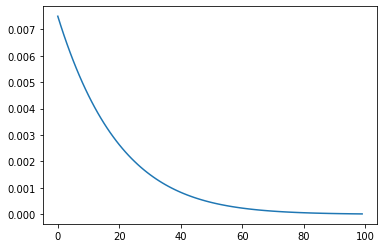

In [ ]:
print(total_losses)
plt.plot(total_losses)
PATH = 'best_model'
print(len(ids))

In [ ]:
extractor = torch.load('best_extractor')
RPNmodel = torch.load('best_rpn')

In [ ]:

images = []
bndboxes = []
classes = []
#only 100 samples
for id in ids[:10]:
  
  img_file = os.path.join(img_dir, id + '.jpg')
  img = Image.open(img_file)
  img = np.asarray(img, dtype=np.int32)
  images.append(img)

  img_bndboxes = []
  img_classes = []

  anno = ET.parse(os.path.join(anno_dir, id + '.xml'))
  for obj in anno.findall('object'):
    class_name = obj.find('name').text
    if class_name not in class_dict:
      class_dict[class_name] = class_idx
      class_idx += 1
      class_names.append(class_name)
    img_classes.append(class_dict[class_name])
      
    bndbox = obj.find('bndbox')
    img_bndboxes.append(
        [int(bndbox.find(tag).text) for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
    )
  bndboxes.append(img_bndboxes)
  classes.append(img_classes)

def rpn_eval(rpnmodel, extractor, N=1, l=1):
  rpnmodel.eval()
  extractor.eval()
  
  Y_pred_boxes = []
  G_boxes = []
  losses = []
  A_boxes = []
  for i in range(len(images)):
    #---get data---#
    
    X, G_box, G_cls = get_batch(i)
    A_flat = create_anchors(X)
    y_cls, y_box = map_anchors_to_Gbox(A_flat, G_box, G_cls)
    y_cls_sampled = sampled_box_idx(y_cls)
    
    with torch.no_grad():
        
      #---input to model----#
      h = extractor(X)
      h_cls, h_box = rpnmodel(h)
      

      #---output-----#
      H = h_cls.size(2)
      W = h_box.size(3)
      _h_cls = h_cls.view(-1, n_anchor*2, H*W) # N C H*W
      _h_cls = _h_cls.permute(0, 2, 1).contiguous() # N H*W C
      _h_cls = _h_cls.view(-1, H*W*n_anchor, 2) # N H*W*2 C 
      h_cls_flat = F.log_softmax(_h_cls, dim=-1)
        
      _h_box = h_box.view(-1, n_anchor*4, H*W)
      _h_box = _h_box.permute(0, 2, 1).contiguous()
      h_box_flat = _h_box.view(-1, H*W*n_anchor, 4)

      #----loss(cls, loc)----#
      h_cls_flat_sampled = h_cls_flat[0, y_cls_sampled]
      L_cls = F.nll_loss(h_cls_flat_sampled, y_cls[y_cls_sampled])

      L_loc = get_L_loc(A_flat, h_box_flat, y_box, y_cls)

      loss = L_cls + l * L_loc

      #----after---#
      losses.append(loss.item())
      Y_pred_boxes.append(h_box_flat[0][y_cls == 1])
      A_boxes.append(A_flat[y_cls == 1])
      G_boxes.append(G_box[0])

  return sum(losses), Y_pred_boxes, G_boxes, A_boxes
sum_losses, Y_pred_boxes, G_boxes, A_boxes = \
    rpn_eval(RPNmodel, extractor, 1, 1)
print(sum_losses)  

605.5789199408518


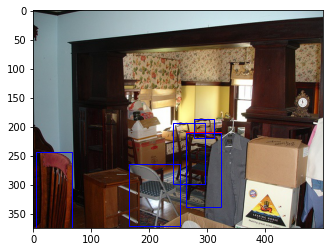

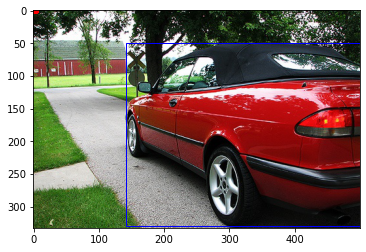

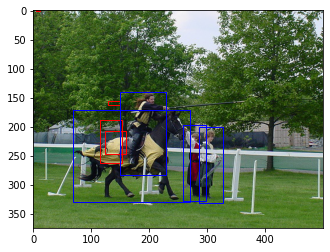

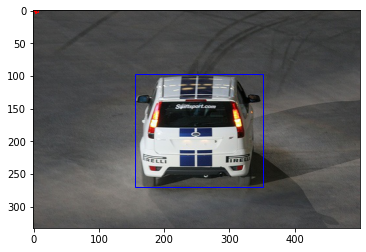

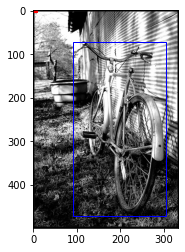

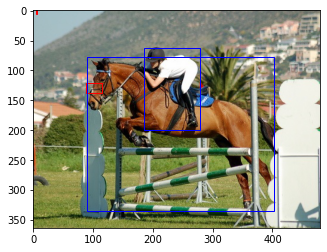

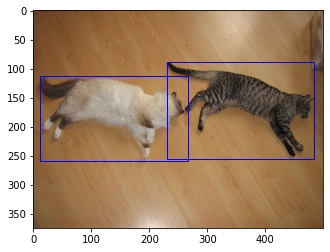

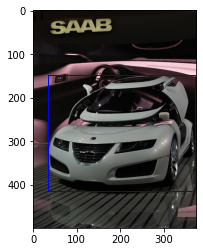

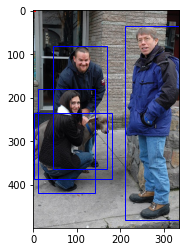

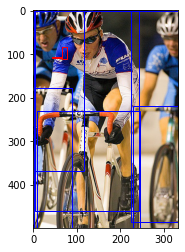

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

for i in range(len(Y_pred_boxes)):
  fig = plt.figure(i)
  plt.imshow(images[i])
  pred_boxes = Y_pred_boxes[i]
  a_boxes = A_boxes[i]
  for j in range(len(pred_boxes)):
    pred_box = pred_boxes[j]
    xx = pred_box[0]
    xy = pred_box[1]
    yx = pred_box[2]
    yy = pred_box[3]
    w = yx-xx
    h = yy-xy
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r',facecolor='none'))
  g_boxes = G_boxes[i]
  for j in range(len(g_boxes)):
    g_box = g_boxes[j]
    xx = g_box[0]
    xy = g_box[1]
    yx = g_box[2]
    yy = g_box[3]
    w = yx-xx
    h = yy-xy
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='b',facecolor='none'))
  """for j in range(len(a_boxes)):
    a_box = a_boxes[j]
    xx = a_box[0]
    xy = a_box[1]
    yx = a_box[2]
    yy = a_box[3]
    w = yx-xx
    h = yy-xy
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='g',facecolor='none'))
  """

In [ ]:
print(Y_pred_boxes[0])

tensor([[ 107.9637,  934.2115,  420.6466, -577.1235],
        [ 233.5844,  303.6284,  301.1201,  186.7461],
        [ 311.6407,  214.0226,  271.5128,  335.9699],
        [  65.8929,  244.3472,    2.6988,  383.0657],
        [  68.7387,  230.0086,    3.4652,  367.0743],
        [ 151.6609,  362.4861,  258.8409,  267.2418]], device='cuda:0')


In [ ]:
print(Y_pred_boxes[0])

tensor([[792.1569,  45.2110,  53.7650, 627.7374],
        [458.1439,  86.9639, 133.7205, 347.5479],
        [373.2161,  76.1638, 134.5386, 303.9865],
        [312.8639,  91.3587, -94.1087, 168.0962],
        [301.6619,  69.4991, -38.3377, 166.7222],
        [374.5051, 118.4527,  34.4494, 228.1621]], device='cuda:0')
